#### Example of text classification Keras' Stacked LSTM

Reference pages:
- https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
- https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
- https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/
- https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

The dataset was preprocessed in **finance complaints dataset analysis** notebook.

Loading balanced dataset.

In [1]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
print(df.isnull().sum())
df.head()

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",My XXXX XXXX Account Was Paid Off But They Hav...,0
1,1,"Credit reporting, credit repair services, or o...",I had a citibank checking account which I clos...,0
2,2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,0
3,3,"Credit reporting, credit repair services, or o...",Account from XXXX with a balance is reporting ...,0
4,4,"Credit reporting, credit repair services, or o...",The credit bureaus are reporting inaccurate/ou...,0


Text preprocessing

In [2]:
%%time
import re
from nltk.corpus import stopwords

text = df.Consumer_complaint_narrative

# removing XXX words
text = text.apply(lambda x: re.sub(r'X{2,}', '', x))

# converting to lower case
text = text.apply(lambda x: x.lower())

# replacing symbols with spaces
text = text.apply(lambda x: re.sub(r'[/(){}\[\]\|@,;]', ' ', x))

# removing bad symbols
text = text.apply(lambda x: re.sub(r'[^0-9a-z #+_]', '', x))

# removing numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# removing stop words
STOPWORDS = set(stopwords.words('english'))
text = text.apply(lambda x: ' '.join(word for word in x.split() if word not in STOPWORDS))

CPU times: user 1.32 s, sys: 60 ms, total: 1.38 s
Wall time: 1.38 s


In [3]:
def print_example(index):
    print("-"*50)
    print("* BEFORE: {}".format(df.Consumer_complaint_narrative[index]))
    print("\n* AFTER: {}\n".format(text[index]))
    
print_example(0)
print_example(10)
print_example(50)

--------------------------------------------------
* BEFORE: My XXXX XXXX Account Was Paid Off But They Have Left The Wrong Information On My Credit Report For 11 Years The Account Should Be Removed It Is Too OldAnd A Medical Account That I Believed To Be Payed Off Has Also Been Left On My Report

* AFTER: account paid left wrong information credit report years account removed oldand medical account believed payed also left report

--------------------------------------------------
* BEFORE: Please be advised this is my THIRD WRITTEN REQUEST and FINAL WARNING that I fully intend to pursue litigation in accordance with the FCRA to enforce my rights and seek relief and recover all monetary damages that I may be entitled to under Section 616 and Section 617 regarding your continued willful and negligent noncompliance.

Despite two written requests, the unverified items listed below still remain on my credit report in violation of Federal Law. You are required under the FCRA to have a copy

Creating train and test sets, with balanced frequency of classes.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encoding labels to one hot vectors
encoder = LabelEncoder()
encoder.fit(df['category_id'])
encoded_Y = encoder.transform(df['category_id'])
Y = np_utils.to_categorical(encoded_Y)

sss = StratifiedShuffleSplit(n_splits=1, 
                             test_size=0.3, 
                             random_state=0)
for train_index, test_index in sss.split(text, Y):
    train_sentences = text.loc[train_index]
    Y_train = Y[train_index]
    test_sentences = text.loc[test_index]
    test_labels = df['category_id'].loc[test_index]
    Y_test = Y[test_index]

Using TensorFlow backend.


**Preparing the input**

The `Tokenizer` utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. We can add the parameter `num_words`, which is responsible for setting the size of the vocabulary. The most common `num_words` words will be then kept.

In [5]:
%%time
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

train_seqs = tokenizer.texts_to_sequences(train_sentences)
test_seqs = tokenizer.texts_to_sequences(test_sentences)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: {}'.format(vocab_size))

Vocabulary size: 10883
CPU times: user 502 ms, sys: 68 µs, total: 502 ms
Wall time: 501 ms


With Tokenizer, the resulting vectors equal the length of each text, and the resulting vectors won't have the same length. To counter this, you can use `pad_sequence()` which simply pads the sequence of words with zeros. By default, it prepends zeros but we will to append them. Additionally you would want to add a `maxlen` parameter to specify how long the sequences should be. This cuts sequences that exceed that number.

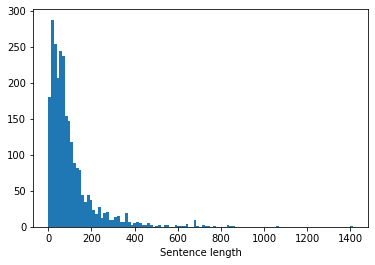

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# analyzing the sentences' length
freqs = pd.Series(train_seqs).apply(lambda x: len(x))
plt.hist(freqs, bins='auto') 
plt.xlabel('Sentence length');

In [7]:
from keras.preprocessing.sequence import pad_sequences

max_sentence_len = 30

X_train = pad_sequences(train_seqs, padding='post', maxlen=max_sentence_len)
X_test = pad_sequences(test_seqs, padding='post', maxlen=max_sentence_len)

**Word Embeddings**

In order to speed the LSTM training, the word embeddings will be previously generated through Word2Vec.

In [8]:
%%time

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
def sequence_to_text(list_of_indices):
    words = [reverse_word_map.get(i) for i in list_of_indices]
    return(words)

# Creating texts 
w2v_input = list(map(sequence_to_text, train_seqs))

CPU times: user 44.9 ms, sys: 7.86 ms, total: 52.7 ms
Wall time: 52 ms


In [9]:
%%time
import gensim

embedding_dim = 50
word_model = gensim.models.Word2Vec(w2v_input, 
                                    size=embedding_dim, 
                                    min_count=1, 
                                    iter=10)

CPU times: user 11.2 s, sys: 52.4 ms, total: 11.2 s
Wall time: 6.1 s


**Creating and traning the model**

We will use the Embedding Layer of Keras to store the embedding vectors generated by Word2Vec.

- `input_dim`: the size of the vocabulary (i.e., the number of neurons).
- `output_dim`: the size of the dense vector generated by the layer.
- `input_length`: the length of the input sequence/document.

In [10]:
from keras import layers
import numpy as np

word_index = tokenizer.word_index

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in word_model.wv.vocab:
        embedding_matrix[i] = word_model.wv.get_vector(word)
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

embedding_layer = layers.Embedding(embedding_matrix.shape[0], # or len(word_index) + 1
                            embedding_matrix.shape[1], # or EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_sentence_len,
                            trainable=False)

Null word embeddings: 1


In [11]:
from keras.models import Sequential
from keras import layers
from keras import initializers

k_initializer = initializers.glorot_uniform(seed=1)
r_initializer = initializers.Orthogonal(seed=1)

model = Sequential()
model.add(embedding_layer)
model.add(layers.LSTM(30, 
                      return_sequences=True, 
                      dropout=0.2, 
                      recurrent_dropout=0.2, 
                      kernel_initializer=k_initializer, 
                      recurrent_initializer=r_initializer))
model.add(layers.LSTM(30, 
                      return_sequences=True, 
                      dropout=0.2, 
                      recurrent_dropout=0.2, 
                      kernel_initializer=k_initializer, 
                      recurrent_initializer=r_initializer))
model.add(layers.LSTM(30, 
                      dropout=0.2, 
                      recurrent_dropout=0.2, 
                      kernel_initializer=k_initializer, 
                      recurrent_initializer=r_initializer))
model.add(layers.Dense(30, 
                      activation="relu", 
                      kernel_initializer=k_initializer))
model.add(layers.Dense(5, 
                      activation="softmax", 
                      kernel_initializer=k_initializer))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 50)            544150    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 30)            9720      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 155       
Total params: 569,595
Trainable params: 25,445
Non-trainable params: 544,150
___________________________________________

Training the model.

In [12]:
%%time
history = model.fit(X_train, 
                    Y_train,
                    epochs=60,
                    verbose=False,
                    validation_data=(X_test, Y_test),
                    batch_size=64)

CPU times: user 21min 23s, sys: 18min 3s, total: 39min 27s
Wall time: 10min 1s


Evaluation.

Training Accuracy: 0.8414
Testing Accuracy:  0.7590


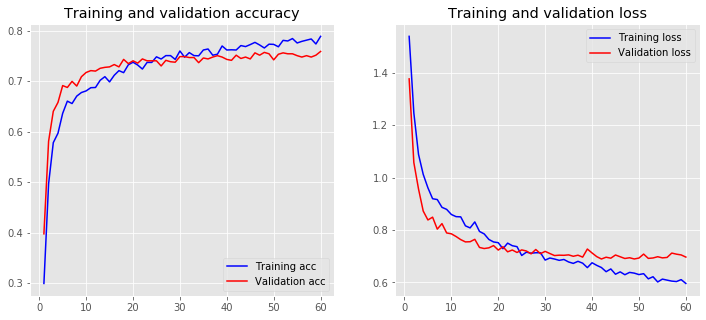

In [13]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

loss, accuracy = model.evaluate(X_train, 
                                Y_train, 
                                verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, 
                                Y_test, 
                                verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_tags = df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

accuracy 0.7590361445783133
confusion matrix
 [[166  19  19   8   4]
 [ 20 162  13  15   6]
 [ 12  12 132  13  46]
 [  7   7  17 173  12]
 [  4   3  18   5 186]]
(row=expected, col=predicted)
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       216
           1       0.80      0.75      0.77       216
           2       0.66      0.61      0.64       215
           3       0.81      0.80      0.80       216
           4       0.73      0.86      0.79       216

    accuracy                           0.76      1079
   macro avg       0.76      0.76      0.76      1079
weighted avg       0.76      0.76      0.76      1079



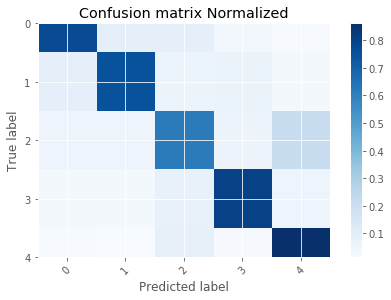

In [15]:
import numpy as np
from sklearn import metrics

Y_pred = model.predict(X_test, 
                       verbose=0)
evaluate_prediction(Y_pred.argmax(axis=1), 
                    Y_test.argmax(axis=1))

print(metrics.classification_report(Y_test.argmax(axis=1), 
                                    Y_pred.argmax(axis=1)))